# Problem Statement

Given the recent history of a user's interactions with previous email campaigns, can you predict the success of the next one? This is a common business problem, but one that it is usually hard to find real, publicly accessible datasets for.

## Background

The aim of this project is to build a model that can predict whether a user opens the emails sent by Shopee.

Sending emails is one of the marketing channels Shopee uses to reach out to our users. Being able to predict whether a user opens an email allows Shopee to forecast and evaluate the performance of future marketing campaigns before launch. This is because when a user opens an email, the probability of the user knowing the campaign increases and this in turn increases the probability of the user making a checkout during the campaign period. Therefore, with the predicted open rates, Shopee can better develop, strategize and implement future marketing campaigns.

## Task

We provide you with data related to marketing emails (Electronic Direct Mail) that were sent to Shopee users over a certain period. It contains information about

User-specific information Email nature Users’ engagement on the platform User’s reaction to the email, including whether users opened the email Based on the data provided, you must predict whether each user will open an email sent to him/her.

### Files

[train/test].csv

country_code: An integer code for the country where the user lives.

grass_date: The date when the email was sent.

user_id: the unique identifier of each user

subject_line_length: the number of characters in the subject of the email

last_open_day: How many days ago was the last time the user opened an email

last_login_day: How many days ago the user last logged in its Shopee account

last_checkout_day: How many days ago the user last purchased on Shopee

open_count_last_[10/30/60]_days: the total number of email opens in the last N days.

login_count_last_[10/30/60]_days: the total number of user logins in the last N days.

checkout_count_last_[10/30/60]_days: the total number of checkouts (=purchases) by the user in the last N days.

open_flag: the target variable. Whether or not the email was opened.

row_id:

users.csv [empty values are simply unknown]

user_id: the unique identifier of each user

attr_[1/2/3]: general user attributes. Attr_1 and attr_2 are boolean, attrib_3 can be integer [0,1,2,3,4].

age: The user's reported age.

domain: The user's top-level email domain. Less common domains are bundled together under the label 'other'.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


Import Libraries

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline, make_pipeline
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, BaggingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_curve, roc_auc_score, auc, classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import SCORERS

from sklearn.metrics import matthews_corrcoef
%matplotlib inline

In [ ]:
train = pd.read_csv('/content/gdrive/My Drive/Marketing Analytics/train.csv', parse_dates=['grass_date'])
test = pd.read_csv('/content/gdrive/My Drive/Marketing Analytics/test.csv', parse_dates=['grass_date'])
users = pd.read_csv('/content/gdrive/My Drive/Marketing Analytics/users.csv')

In [ ]:
train.head()

,country_code,grass_date,user_id,subject_line_length,last_open_day,last_login_day,last_checkout_day,open_count_last_10_days,open_count_last_30_days,open_count_last_60_days,login_count_last_10_days,login_count_last_30_days,login_count_last_60_days,checkout_count_last_10_days,checkout_count_last_30_days,checkout_count_last_60_days,open_flag,row_id
0,4,2019-07-16 00:00:00+08:00,43,44,19,6,18,0,2,4,12,43,99,0,5,10,0,0
1,4,2019-07-16 00:00:00+08:00,102,44,9,4,8,2,9,17,18,48,90,1,1,4,1,1
2,6,2019-07-16 00:00:00+08:00,177,49,14,5,5,0,4,12,24,69,119,5,19,27,0,2
3,1,2019-07-16 00:00:00+08:00,184,49,49,9,53,0,0,1,9,23,69,1,3,6,0,3
4,6,2019-07-16 00:00:00+08:00,221,49,227,6,221,0,0,0,2,5,5,0,0,0,0,4


In [ ]:
users.head()

,user_id,attr_1,attr_2,attr_3,age,domain
0,0,NaN,1.0,0.0,NaN,@gmail.com
1,1,1.0,1.0,2.0,50.0,@gmail.com
2,2,NaN,1.0,0.0,NaN,other
3,3,NaN,1.0,0.0,NaN,@gmail.com
4,4,1.0,1.0,2.0,33.0,@gmail.com


Data Cleaning

In [ ]:
# Merge train and users on user_id
train_df = train.merge(users, on='user_id')

# Merge test and users on user_id
test_df = test.merge(users, on='user_id')

In [ ]:
# last_open_day, last_login_day and last_checkout_day are currently object types but should be integers
# Some null values for attr_1 and attr_2
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 73539 entries, 0 to 73538
Data columns (total 23 columns):
 #   Column                       Non-Null Count  Dtype                                
---  ------                       --------------  -----                                
 0   country_code                 73539 non-null  int64                                
 1   grass_date                   73539 non-null  datetime64[ns, pytz.FixedOffset(480)]
 2   user_id                      73539 non-null  int64                                
 3   subject_line_length          73539 non-null  int64                                
 4   last_open_day                73539 non-null  object                               
 5   last_login_day               73539 non-null  object                               
 6   last_checkout_day            73539 non-null  object                               
 7   open_count_last_10_days      73539 non-null  int64                                
 8   open_c

In [ ]:
# checking for missing values
train_df.isnull().sum()

country_code                       0
grass_date                         0
user_id                            0
subject_line_length                0
last_open_day                      0
last_login_day                     0
last_checkout_day                  0
open_count_last_10_days            0
open_count_last_30_days            0
open_count_last_60_days            0
login_count_last_10_days           0
login_count_last_30_days           0
login_count_last_60_days           0
checkout_count_last_10_days        0
checkout_count_last_30_days        0
checkout_count_last_60_days        0
open_flag                          0
row_id                             0
attr_1                         28192
attr_2                           279
attr_3                             0
age                            28192
domain                             0
dtype: int64

In [ ]:
test_df.isnull().sum()

country_code                       0
grass_date                         0
user_id                            0
subject_line_length                0
last_open_day                      0
last_login_day                     0
last_checkout_day                  0
open_count_last_10_days            0
open_count_last_30_days            0
open_count_last_60_days            0
login_count_last_10_days           0
login_count_last_30_days           0
login_count_last_60_days           0
checkout_count_last_10_days        0
checkout_count_last_30_days        0
checkout_count_last_60_days        0
row_id                             0
attr_1                         21233
attr_2                           168
attr_3                             0
age                            21233
domain                             0
dtype: int64

In [ ]:
train['open_flag'].value_counts(normalize=True)

0    0.844219
1    0.155781
Name: open_flag, dtype: float64

# Feature engineering - Cyclical data

In [ ]:
# #extracitng the year, month and day from the grass_date
# # time has found to be consisitent (+08:00) across all rows 
# train_df['year'] = train_df['grass_date'].map(lambda x: x.year)
# train_df['month'] = train_df['grass_date'].map(lambda x: x.month)
# train_df['day'] = train_df['grass_date'].map(lambda x: x.day)

In [ ]:
# #cyclical features for month
# train_df['month_sin'] = np.sin(train_df['month']*(2.*np.pi/12))
# train_df['month_cos'] = np.cos(train_df['month']*(2.*np.pi/12))

# #cyclical features for day
# #assumption that every month has 31 days
# train_df['day_sin'] = np.sin(train_df['day']*(2.*np.pi/31))
# train_df['day_cos'] = np.cos(train_df['day']*(2.*np.pi/31))

# #dropping grass_date, month, day
# # train_df.drop(['grass_date', 'month', 'day'],axis=1, inplace=True)

# Imputing missing data

### Last open day/ last check in/ last log out

In [ ]:
# Listed as an object type as there are some words in last_open_day
train_df[train_df['last_open_day']=='Never open'].head()

,country_code,grass_date,user_id,subject_line_length,last_open_day,last_login_day,last_checkout_day,open_count_last_10_days,open_count_last_30_days,open_count_last_60_days,login_count_last_10_days,login_count_last_30_days,login_count_last_60_days,checkout_count_last_10_days,checkout_count_last_30_days,checkout_count_last_60_days,open_flag,row_id,attr_1,attr_2,attr_3,age,domain
14,2,2019-07-16 00:00:00+08:00,635,36,Never open,44,57,0,0,0,0,0,6,0,0,1,0,14,NaN,1.0,0.0,NaN,@hotmail.com
23,2,2019-07-16 00:00:00+08:00,1162,43,Never open,382,16,0,0,0,0,0,0,0,0,0,0,23,1.0,1.0,2.0,39.0,@hotmail.com
24,2,2019-07-16 00:00:00+08:00,1165,36,Never open,135,468,0,0,0,0,0,0,0,0,0,0,24,1.0,1.0,2.0,26.0,@gmail.com
72,2,2019-07-16 00:00:00+08:00,3566,43,Never open,327,499,0,0,0,0,0,0,0,0,0,0,71,1.0,1.0,2.0,28.0,@gmail.com
91,2,2019-07-16 00:00:00+08:00,4648,46,Never open,1,76,0,0,0,2,2,5,0,0,0,0,89,1.0,1.0,2.0,36.0,@gmail.com


In [ ]:
# Replace "Never open" with a very high number, like 1000
train_df['last_open_day'] = train_df['last_open_day'].map(lambda x: 1000 if x=='Never open' else x).astype(int)

# Replace "Never login" with a very high number, like 20,000
train_df['last_login_day'] = train_df['last_login_day'].map(lambda x: 20000 if x=='Never login' else x).astype(int)

# Replace "Never login" with a very high number, like 20000
train_df['last_checkout_day'] = train_df['last_checkout_day'].map(lambda x: 20000 if x=='Never checkout' else x).astype(int)

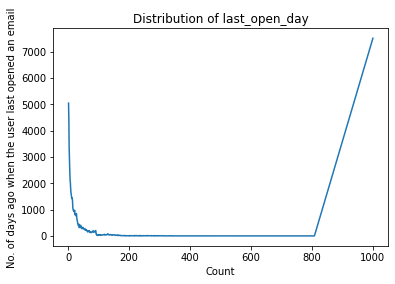

In [ ]:
train_df['last_open_day'].value_counts().sort_index().plot()
plt.title('Distribution of last_open_day')
plt.ylabel('No. of days ago when the user last opened an email')
plt.xlabel('Count');

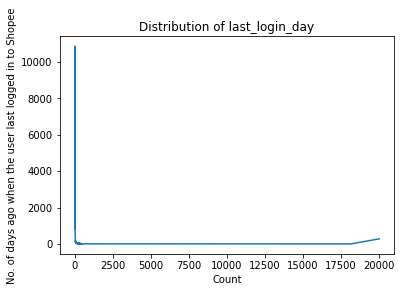

In [ ]:
train_df['last_login_day'].value_counts().sort_index().plot()
plt.title('Distribution of last_login_day')
plt.ylabel('No. of days ago when the user last logged in to Shopee')
plt.xlabel('Count');

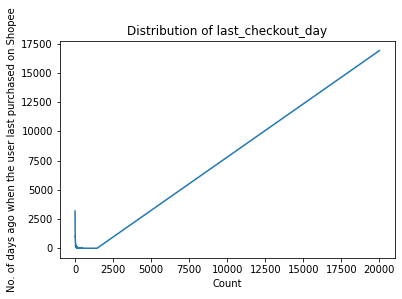

In [ ]:
train_df['last_checkout_day'].value_counts().sort_index().plot()
plt.title('Distribution of last_checkout_day')
plt.ylabel('No. of days ago when the user last purchased on Shopee')
plt.xlabel('Count');

### attr_1 and attr_2

count    45347.000000
mean         0.999757
std          0.015573
min          0.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: attr_1, dtype: float64


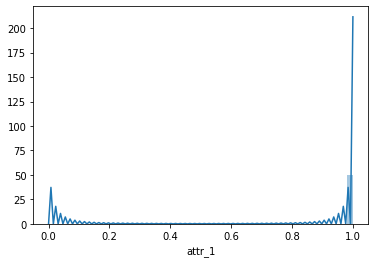

In [ ]:
#distribution of attr_1

print(train_df['attr_1'].describe())
sns.distplot(train_df['attr_1'])

count    73260.000000
mean         0.997256
std          0.052308
min          0.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: attr_2, dtype: float64


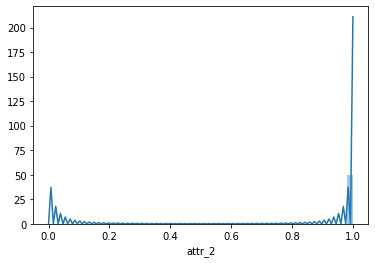

In [ ]:
#distribution of attr_2

print(train_df['attr_2'].describe())
sns.distplot(train_df['attr_2'])

In [ ]:
# Fill NA with 1

train_df['attr_1'].fillna(1, inplace=True)
train_df['attr_2'].fillna(1, inplace=True)

In [ ]:
# Need to fill NA and treat ages that are too young or too old
sorted(train_df['age'].unique())

[-17.0,
 -16.0,
 0.0,
 1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 19.0,
 20.0,
 21.0,
 22.0,
 23.0,
 24.0,
 25.0,
 26.0,
 27.0,
 28.0,
 29.0,
 30.0,
 31.0,
 32.0,
 33.0,
 34.0,
 35.0,
 36.0,
 37.0,
 38.0,
 39.0,
 40.0,
 47.0,
 nan,
 41.0,
 42.0,
 43.0,
 44.0,
 45.0,
 46.0,
 48.0,
 49.0,
 50.0,
 51.0,
 52.0,
 53.0,
 54.0,
 55.0,
 56.0,
 57.0,
 58.0,
 59.0,
 60.0,
 61.0,
 62.0,
 63.0,
 64.0,
 65.0,
 66.0,
 67.0,
 68.0,
 69.0,
 70.0,
 71.0,
 72.0,
 73.0,
 74.0,
 75.0,
 76.0,
 80.0,
 81.0,
 92.0,
 93.0,
 95.0,
 97.0,
 98.0,
 99.0,
 100.0,
 101.0,
 104.0,
 105.0,
 107.0,
 108.0,
 109.0,
 110.0,
 112.0,
 114.0,
 115.0,
 118.0]

In [ ]:
sorted(test_df['age'].unique())

[nan,
 0.0,
 1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 19.0,
 20.0,
 21.0,
 22.0,
 23.0,
 24.0,
 25.0,
 26.0,
 27.0,
 28.0,
 29.0,
 30.0,
 31.0,
 32.0,
 33.0,
 34.0,
 35.0,
 36.0,
 37.0,
 38.0,
 39.0,
 40.0,
 41.0,
 42.0,
 43.0,
 44.0,
 45.0,
 46.0,
 47.0,
 48.0,
 49.0,
 50.0,
 51.0,
 52.0,
 53.0,
 54.0,
 55.0,
 56.0,
 57.0,
 58.0,
 59.0,
 60.0,
 61.0,
 62.0,
 63.0,
 64.0,
 65.0,
 66.0,
 67.0,
 68.0,
 69.0,
 70.0,
 71.0,
 72.0,
 73.0,
 74.0,
 75.0,
 76.0,
 77.0,
 80.0,
 87.0,
 91.0,
 92.0,
 93.0,
 95.0,
 98.0,
 100.0,
 103.0,
 105.0,
 106.0,
 107.0,
 109.0,
 110.0,
 112.0,
 114.0,
 115.0,
 116.0,
 117.0,
 118.0]

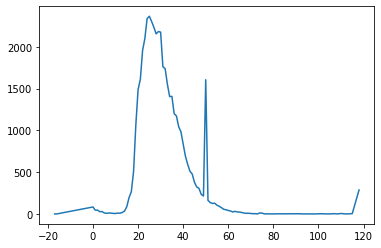

In [ ]:
# Age distribution
train_df['age'].value_counts().sort_index().plot();

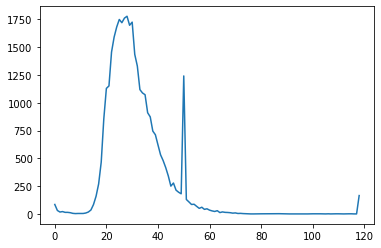

In [ ]:
# Age distribution
test_df['age'].value_counts().sort_index().plot();

In [ ]:
train_df['age'].median()

29.0

In [ ]:
train_df[train_df['age'].isnull()]

,country_code,grass_date,user_id,subject_line_length,last_open_day,last_login_day,last_checkout_day,open_count_last_10_days,open_count_last_30_days,open_count_last_60_days,login_count_last_10_days,login_count_last_30_days,login_count_last_60_days,checkout_count_last_10_days,checkout_count_last_30_days,checkout_count_last_60_days,open_flag,row_id,attr_1,attr_2,attr_3,age,domain
2,6,2019-07-16 00:00:00+08:00,177,49,14,5,5,0,4,12,24,69,119,5,19,27,0,2,1.0,1.0,0.0,NaN,@yahoo.com
4,6,2019-07-16 00:00:00+08:00,221,49,227,6,221,0,0,0,2,5,5,0,0,0,0,4,1.0,1.0,0.0,NaN,@hotmail.com
8,1,2019-07-16 00:00:00+08:00,350,49,7,5,26,2,4,7,1,8,10,0,1,1,1,8,1.0,1.0,0.0,NaN,@yahoo.com
14,2,2019-07-16 00:00:00+08:00,635,36,1000,44,57,0,0,0,0,0,6,0,0,1,0,14,1.0,1.0,0.0,NaN,@hotmail.com
26,1,2019-07-16 00:00:00+08:00,1217,64,70,1396,20000,0,0,0,0,0,0,0,0,0,0,26,1.0,1.0,0.0,NaN,@gmail.com
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73532,1,2019-09-02 00:00:00+08:00,127595,33,8,18,20000,1,3,3,0,0,0,0,0,0,0,73532,1.0,1.0,0.0,NaN,@gmail.com
73533,3,2019-09-02 00:00:00+08:00,127610,49,24,1083,1087,0,3,4,0,0,0,0,0,0,1,73533,1.0,1.0,0.0,NaN,@gmail.com
73534,6,2019-09-02 00:00:00+08:00,127613,39,24,36,279,0,1,1,0,0,0,0,0,0,0,73534,1.0,1.0,0.0,NaN,@hotmail.com
73536,2,2019-09-02 00:00:00+08:00,127696,32,1000,20000,20000,0,0,0,0,0,0,0,0,0,0,73536,1.0,1.0,0.0,NaN,@gmail.com


In [ ]:
# Let's fill NA with median age. 
train_df['age'].fillna(train_df['age'].median(), inplace=True)

In [ ]:
#There is also very old in the test data set. So i only clean the negative age to be 0
train_df[train_df['age']<0]

,country_code,grass_date,user_id,subject_line_length,last_open_day,last_login_day,last_checkout_day,open_count_last_10_days,open_count_last_30_days,open_count_last_60_days,login_count_last_10_days,login_count_last_30_days,login_count_last_60_days,checkout_count_last_10_days,checkout_count_last_30_days,checkout_count_last_60_days,open_flag,row_id,attr_1,attr_2,attr_3,age,domain
56025,3,2019-08-22 00:00:00+08:00,86151,52,37,128,259,0,0,0,0,0,0,0,0,0,0,55774,1.0,1.0,3.0,-17.0,@gmail.com
59897,5,2019-08-26 00:00:00+08:00,1973,31,30,2,2,0,0,7,8,25,28,1,4,5,0,59683,1.0,1.0,2.0,-16.0,@gmail.com


In [ ]:
train_df['age'] = train_df['age'].map(lambda x: 0 if x<0 else x)

In [ ]:
# Check that the data types are now correct and that there are no null values.
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 73539 entries, 0 to 73538
Data columns (total 23 columns):
 #   Column                       Non-Null Count  Dtype                                
---  ------                       --------------  -----                                
 0   country_code                 73539 non-null  int64                                
 1   grass_date                   73539 non-null  datetime64[ns, pytz.FixedOffset(480)]
 2   user_id                      73539 non-null  int64                                
 3   subject_line_length          73539 non-null  int64                                
 4   last_open_day                73539 non-null  int64                                
 5   last_login_day               73539 non-null  int64                                
 6   last_checkout_day            73539 non-null  int64                                
 7   open_count_last_10_days      73539 non-null  int64                                
 8   open_c

Feature Engineering

In [ ]:
cuurent_cols = [ 'open_count_last_10_days', 'open_count_last_30_days', 'open_count_last_60_days']
current_threshold = [12, 30, 56]

for col, val in zip(cuurent_cols, current_threshold):
    print("Change", (train_df[col] > val).sum(), "Rows from", col)
    train_df.loc[train_df[col] > val, col] = val

Change 22 Rows from open_count_last_10_days
Change 43 Rows from open_count_last_30_days
Change 32 Rows from open_count_last_60_days


In [ ]:
# Don't feature engineer month as it is not very reproducible in the test data
# train_df['month'] = train_df['grass_date'].dt.month

In [ ]:
# # Create a day of the week feature, for which the email was sent
train_df['day_of_the_week'] = train_df['grass_date'].dt.weekday

In [ ]:
# # FYI 0 represents Monday
# train_df['day'].unique()

EDA

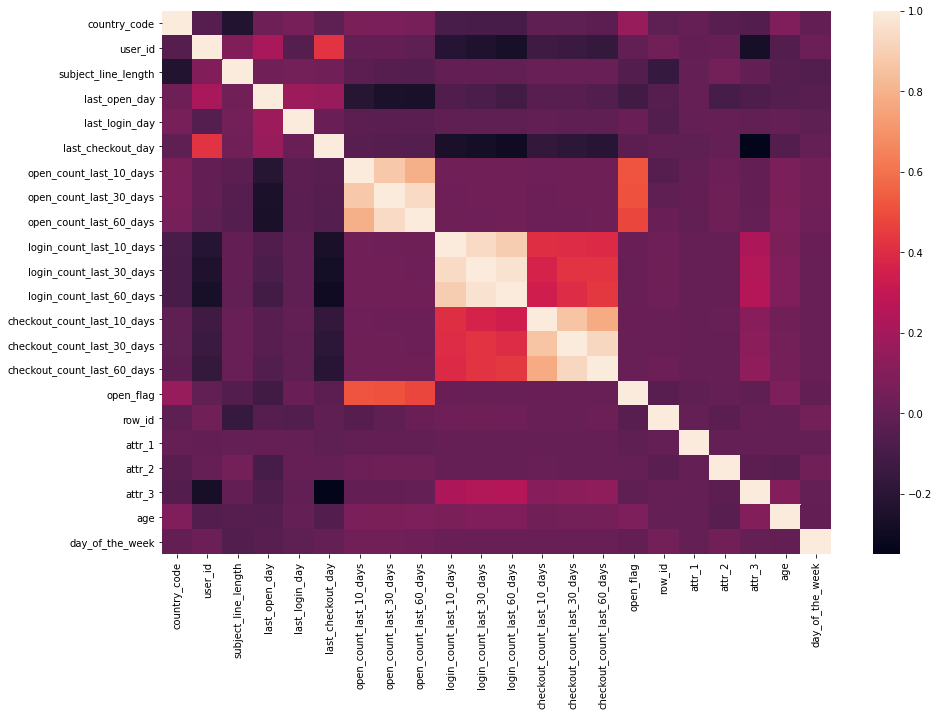

In [ ]:
plt.figure(figsize=(15,10))
sns.heatmap(train_df.corr());

In [ ]:
# open_count has quite strong correlation with our target variable, open_flag
train_df.corr()['open_flag'].sort_values(ascending=False)

open_flag                      1.000000
open_count_last_10_days        0.517244
open_count_last_30_days        0.510572
open_count_last_60_days        0.479796
country_code                   0.158945
age                            0.080582
last_login_day                 0.018489
checkout_count_last_10_days    0.015573
login_count_last_10_days       0.014023
checkout_count_last_30_days    0.013419
checkout_count_last_60_days    0.010231
login_count_last_30_days       0.010134
login_count_last_60_days       0.008633
attr_2                         0.001661
day_of_the_week               -0.003278
user_id                       -0.008082
attr_1                        -0.013143
attr_3                        -0.014235
last_checkout_day             -0.026779
row_id                        -0.037443
subject_line_length           -0.057357
last_open_day                 -0.116285
Name: open_flag, dtype: float64

In [ ]:
# # Country_code is actually a categorical variable. Since customers in country 4 have a higher probability of opening an email, we should one-hot encode this variable
# train_df.groupby('country_code')['open_flag'].mean().plot(kind='bar')
# plt.ylabel('Mean probability of opening an email');

In [ ]:
# # The probability of opening emails on Weds is higher than on other days. We can one-hot encode this variable too
# train_df.groupby('day')['open_flag'].mean().plot(kind='bar')
# plt.ylabel('Mean probability of opening an email');

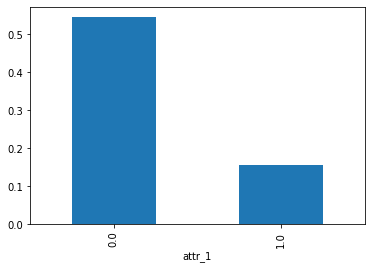

In [ ]:
train_df.groupby('attr_1')['open_flag'].mean().plot(kind='bar');

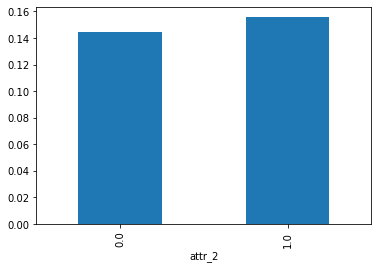

In [ ]:
train_df.groupby('attr_2')['open_flag'].mean().plot(kind='bar');

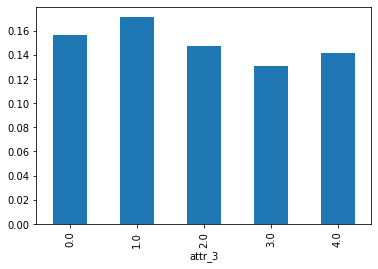

In [ ]:
train_df.groupby('attr_3')['open_flag'].mean().plot(kind='bar');

In [ ]:
# # One-hot encode categorical variables
# train_df = pd.get_dummies(train_df, columns=['country_code', 'day', 'domain', 'attr_3'])
train_df = pd.get_dummies(train_df, 'domain')

In [ ]:
# Drop columns that will not have an influence on the target variable
train_df.drop(columns=['user_id','row_id'], inplace=True)

In [ ]:
train_df.drop(columns=['grass_date'], inplace=True)

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 73539 entries, 0 to 73538
Data columns (total 31 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   country_code                 73539 non-null  int64  
 1   subject_line_length          73539 non-null  int64  
 2   last_open_day                73539 non-null  int64  
 3   last_login_day               73539 non-null  int64  
 4   last_checkout_day            73539 non-null  int64  
 5   open_count_last_10_days      73539 non-null  int64  
 6   open_count_last_30_days      73539 non-null  int64  
 7   open_count_last_60_days      73539 non-null  int64  
 8   login_count_last_10_days     73539 non-null  int64  
 9   login_count_last_30_days     73539 non-null  int64  
 10  login_count_last_60_days     73539 non-null  int64  
 11  checkout_count_last_10_days  73539 non-null  int64  
 12  checkout_count_last_30_days  73539 non-null  int64  
 13  checkout_count_l

Modelling

In [ ]:
def matthewscorrcoef3(estimator, X_val, y_val):
  return matthews_corrcoef(y_val, estimator.predict(X_val))

In [ ]:
# # All features
# X = train_df[[col for col in train_df.columns if col!='open_flag']]
# y = train_df['open_flag']

In [ ]:
# Let's just try top 5 features of importance
features = ['open_count_last_10_days', 'open_count_last_30_days', 'open_count_last_60_days', 'country_code', 'last_open_day', 'day_of_the_week']

X = train_df[features]
y = train_df['open_flag']

In [ ]:
poly = PolynomialFeatures(include_bias=False)

In [ ]:
X_poly = poly.fit_transform(X)

In [ ]:
#open_count_last_30_days * country_code looks promising
X_poly_df = pd.DataFrame(X_poly, columns=poly.get_feature_names(features))
X_poly_df.corrwith(y).sort_values(ascending=False)

open_count_last_10_days                            0.517244
open_count_last_30_days                            0.510572
open_count_last_30_days country_code               0.489104
open_count_last_10_days country_code               0.485094
open_count_last_60_days                            0.479796
open_count_last_60_days country_code               0.461729
open_count_last_10_days open_count_last_30_days    0.445020
open_count_last_10_days open_count_last_60_days    0.435659
open_count_last_30_days^2                          0.435564
open_count_last_10_days^2                          0.434396
open_count_last_30_days open_count_last_60_days    0.426222
open_count_last_60_days^2                          0.403614
open_count_last_10_days day_of_the_week            0.394807
open_count_last_30_days day_of_the_week            0.386272
open_count_last_60_days day_of_the_week            0.362124
country_code                                       0.158945
country_code^2                          

In [ ]:
# Create interaction term
train_df['open_count_last_30_days_country_code'] = train_df['open_count_last_30_days'] * train_df['country_code']

In [ ]:
# Add on interaction term as features
features = ['open_count_last_10_days', 'open_count_last_30_days', 'open_count_last_60_days', 'country_code', 'last_open_day', 'day_of_the_week', 'open_count_last_30_days_country_code']

X = train_df[features]
y = train_df['open_flag']

In [ ]:
# Create a train and validation set
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)

In [ ]:
X_train.shape

(66185, 7)

In [ ]:
y_train.shape

(66185,)

In [ ]:
X_val.shape

(7354, 7)

In [ ]:
y_val.shape

(7354,)

In [ ]:
y_train.value_counts(normalize=True)

0    0.844225
1    0.155775
Name: open_flag, dtype: float64

In [ ]:
y_val.value_counts(normalize=True)

0    0.844166
1    0.155834
Name: open_flag, dtype: float64

Submissions are evaluated on the Matthews correlation coefficient (MCC) between the predicted and the observed response. 

In [ ]:
# Logistic Regression

# Create a pipeline
pipe_lr = make_pipeline(SMOTE(random_state=42),
                        StandardScaler(), # Scale features
                        LogisticRegression(random_state=42, tol=1000))

# Search over the following values of hyperparameters:
pipe_lr_params = {
    'logisticregression__penalty' : ['l2'], # L2 regularization will be better at managing multicollinearity
    'logisticregression__C' : [.001], # Regularization
    'logisticregression__max_iter' : [1000] 
}

# Instantiate GridSearchCV
gs_lr = GridSearchCV(pipe_lr,
                     param_grid=pipe_lr_params,
                     cv=5,
                     scoring=matthewscorrcoef3)

# Fit model on training data
gs_lr.fit(X_train, y_train)

# Generate predictions on validation set
lr_pred = gs_lr.predict(X_val)

# Print best parameters and MCC scores
print('Best parameters: ', gs_lr.best_params_)
print('Best CV MCC score: ', gs_lr.best_score_)
print('Training MCC score:', gs_lr.score(X_train, y_train))
print('Validation MCC score:', gs_lr.score(X_val, y_val))

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

Best parameters:  {'logisticregression__C': 0.001, 'logisticregression__max_iter': 1000, 'logisticregression__penalty': 'l2'}
Best CV MCC score:  0.46367164361016544
Training MCC score: 0.46609803584920667
Validation MCC score: 0.46745110375813487


In [ ]:
y_train.value_counts()

0    55875
1    10310
Name: open_flag, dtype: int64

In [ ]:
# XGBoost

# Create a pipeline
pipe_xgb = make_pipeline(XGBClassifier(random_state=42))

# Search over the following values of hyperparameters:
pipe_xgb_params = {
    'xgbclassifier__eval_metric' : ['auc'],
    'xgbclassifier__subsample' : [0.5], # Randomly sample 0.5 of the data to prevent overfitting
    'xgbclassifier__colsample_bytree' : [0.5], 
    'xgbclassifier__learning_rate' : [0.1], 
    'xgbclassifier__max_depth' : [5], #2, 3
    'xgbclassifier__scale_pos_weight': [55875/10310], # Ratio of negative class to positive class
    'xgbclassifier__n_estimators' : [100], #500
    'xgbclassifier__reg_alpha' : [100], # L1 regularization term on weight #0, 1, 50, 75
    'xgbclassifier__reg_lambda' : [100], # L2 regularization term on weights #0, 1, 2, 50,75
    'xgbclassifier__gamma' : [0.1], # Gamma specifies the minimum loss reduction required to make a split #.2
    'xgbclassifier__objective' : ['binary:logistic']
}

# Instantiate GridSearchCV
gs_xgb = GridSearchCV(pipe_xgb,
                      param_grid=pipe_xgb_params,
                      cv=5,
                      scoring=matthewscorrcoef3)

# Fit model on training data
gs_xgb.fit(X_train, y_train)

# Generate predictions on validation set
xgb_pred = gs_xgb.predict(X_val)

# Print best parameters and MCC scores
print('Best parameters: ', gs_xgb.best_params_)
print('Best CV MCC score: ', gs_xgb.best_score_)
print('Training MCC score:', gs_xgb.score(X_train, y_train))
print('Validation MCC score:', gs_xgb.score(X_val, y_val))

Best parameters:  {'xgbclassifier__colsample_bytree': 0.5, 'xgbclassifier__eval_metric': 'auc', 'xgbclassifier__gamma': 0.1, 'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__max_depth': 5, 'xgbclassifier__n_estimators': 100, 'xgbclassifier__objective': 'binary:logistic', 'xgbclassifier__reg_alpha': 100, 'xgbclassifier__reg_lambda': 100, 'xgbclassifier__scale_pos_weight': 5.419495635305529, 'xgbclassifier__subsample': 0.5}
Best CV MCC score:  0.4764949419393415
Training MCC score: 0.47935836629375855
Validation MCC score: 0.49638469187924433


In [ ]:
# Feature importance for XGBoost
feature_importance = gs_xgb.best_estimator_.named_steps['xgbclassifier'].feature_importances_

# Save feature importance to a dataframe
features_df = pd.DataFrame(index=X_train.columns, data=feature_importance, columns=['feature_importance'])

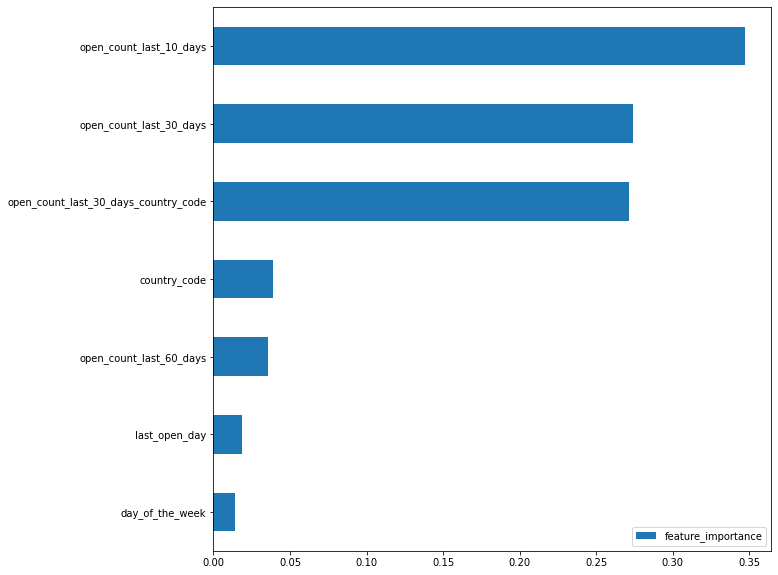

In [ ]:
# Plot the feature importance
features_df.sort_values(by='feature_importance').plot(kind='barh', figsize=(10,10));

Scoring on Kaggle

In [ ]:
train_df.columns

Index(['country_code', 'subject_line_length', 'last_open_day',
       'last_login_day', 'last_checkout_day', 'open_count_last_10_days',
       'open_count_last_30_days', 'open_count_last_60_days',
       'login_count_last_10_days', 'login_count_last_30_days',
       'login_count_last_60_days', 'checkout_count_last_10_days',
       'checkout_count_last_30_days', 'checkout_count_last_60_days',
       'open_flag', 'attr_1', 'attr_2', 'attr_3', 'age', 'year', 'month_sin',
       'month_cos', 'day_sin', 'day_cos', 'domain_@163.com',
       'domain_@gmail.com', 'domain_@hotmail.com', 'domain_@icloud.com',
       'domain_@live.com', 'domain_@outlook.com', 'domain_@qq.com',
       'domain_@rocketmail.com', 'domain_@yahoo.com', 'domain_@ymail.com',
       'domain_other'],
      dtype='object')

In [ ]:
cuurent_cols = [ 'open_count_last_10_days', 'open_count_last_30_days', 'open_count_last_60_days']
current_threshold = [12, 30, 56]

for col, val in zip(cuurent_cols, current_threshold):
    print("Change", (test_df[col] > val).sum(), "Rows from", col)
    test_df.loc[test_df[col] > val, col] = val

Change 23 Rows from open_count_last_10_days
Change 72 Rows from open_count_last_30_days
Change 96 Rows from open_count_last_60_days


In [ ]:
# Replace "Never open" with a very high number, like 1000
test_df['last_open_day'] = test_df['last_open_day'].map(lambda x: 1000 if x=='Never open' else x).astype(int)

# Replace "Never login" with a very high number, like 20,000
test_df['last_login_day'] = test_df['last_login_day'].map(lambda x: 20000 if x=='Never login' else x).astype(int)

# Replace "Never login" with a very high number, like 2000
test_df['last_checkout_day'] = test_df['last_checkout_day'].map(lambda x: 20000 if x=='Never checkout' else x).astype(int)

In [ ]:
# Fill NA with 0
test_df['attr_1'].fillna(1, inplace=True)
test_df['attr_2'].fillna(1, inplace=True)

In [ ]:
# Let's fill NA with median age from training data
test_df['age'].fillna(train_df['age'].median(), inplace=True)

In [ ]:
#training set
test_df['year'] = test_df['grass_date'].map(lambda x: x.year)
test_df['month'] = test_df['grass_date'].map(lambda x: x.month)
test_df['day'] = test_df['grass_date'].map(lambda x: x.day)

#cyclical features for month
test_df['month_sin'] = np.sin(test_df['month']*(2.*np.pi/12))
test_df['month_cos'] = np.cos(test_df['month']*(2.*np.pi/12))

#cyclical features for day
#assumption that every month has 31 days
test_df['day_sin'] = np.sin(test_df['day']*(2.*np.pi/31))
test_df['day_cos'] = np.cos(test_df['day']*(2.*np.pi/31))

#dropping grass_date, month, day
test_df.drop(['grass_date', 'month', 'day'],axis=1, inplace=True)

In [ ]:
# One-hot encode categorical variables
test_df = pd.get_dummies(test_df, columns=['domain'])

In [ ]:
# Drop columns that will not have an influence on the target variable
test_df.drop(columns=['user_id','row_id'], inplace=True)

In [ ]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55970 entries, 0 to 55969
Data columns (total 34 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   country_code                 55970 non-null  int64  
 1   subject_line_length          55970 non-null  int64  
 2   last_open_day                55970 non-null  int64  
 3   last_login_day               55970 non-null  int64  
 4   last_checkout_day            55970 non-null  int64  
 5   open_count_last_10_days      55970 non-null  int64  
 6   open_count_last_30_days      55970 non-null  int64  
 7   open_count_last_60_days      55970 non-null  int64  
 8   login_count_last_10_days     55970 non-null  int64  
 9   login_count_last_30_days     55970 non-null  int64  
 10  login_count_last_60_days     55970 non-null  int64  
 11  checkout_count_last_10_days  55970 non-null  int64  
 12  checkout_count_last_30_days  55970 non-null  int64  
 13  checkout_count_l

## Best model prediction

In [ ]:
y.value_counts()

0    62083
1    11456
Name: open_flag, dtype: int64

In [ ]:
# XGBoost

# Create a pipeline
pipe_xgb = make_pipeline(XGBClassifier(random_state=42))

# Search over the following values of hyperparameters:
pipe_xgb_params = {
    'xgbclassifier__eval_metric' : ['auc'],
    'xgbclassifier__subsample' : [0.5], # Randomly sample 0.5 of the data to prevent overfitting
    'xgbclassifier__colsample_bytree' : [0.5], 
    'xgbclassifier__learning_rate' : [0.1], 
    'xgbclassifier__max_depth' : [5], #2, 3
    'xgbclassifier__scale_pos_weight': [62083/11456], # Ratio of negative class to positive class
    'xgbclassifier__n_estimators' : [100], #500
    'xgbclassifier__reg_alpha' : [100], # L1 regularization term on weight #0, 1, 50, 75
    'xgbclassifier__reg_lambda' : [100], # L2 regularization term on weights #0, 1, 2, 50,75
    'xgbclassifier__gamma' : [0.1], # Gamma specifies the minimum loss reduction required to make a split #.2
    'xgbclassifier__objective' : ['binary:logistic']
}

# Instantiate GridSearchCV
gs_xgb = GridSearchCV(pipe_xgb,
                      param_grid=pipe_xgb_params,
                      cv=5,
                      scoring=matthewscorrcoef3)

# Fit model on full training data
gs_xgb.fit(X, y)

# Print best parameters and MCC scores
print('Best parameters: ', gs_xgb.best_params_)
print('Best CV MCC score: ', gs_xgb.best_score_)

Best parameters:  {'xgbclassifier__colsample_bytree': 0.5, 'xgbclassifier__eval_metric': 'auc', 'xgbclassifier__gamma': 0.1, 'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__max_depth': 3, 'xgbclassifier__n_estimators': 100, 'xgbclassifier__objective': 'binary:logistic', 'xgbclassifier__reg_alpha': 100, 'xgbclassifier__reg_lambda': 100, 'xgbclassifier__scale_pos_weight': 5.419256284916201, 'xgbclassifier__subsample': 0.5}
Best CV MCC score:  0.4103231219460741


In [ ]:
# Generate predictions on test set
xgb_pred = gs_xgb.predict(test_df)

In [ ]:
# Create dataframe for predictions
result = pd.DataFrame(test['row_id'])

In [ ]:
# Save predictions to dataframe
result['open_flag'] = xgb_pred

In [ ]:
# Check first 5 rows of data
result.head()

,row_id,open_flag
0,0,1
1,1,0
2,2,0
3,3,0
4,4,0


In [ ]:
# Sense check
result['open_flag'].value_counts(normalize=True)

0    0.768537
1    0.231463
Name: open_flag, dtype: float64

In [ ]:
# Save predictions to csv
result.to_csv('/content/gdrive/My Drive/Marketing Analytics/result_xgb_4.csv', index=False)